In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
from PIL import Image, ImageDraw, ImageFont
import glob
import cv2
import numpy as np
import re

In [10]:
csv_dataset = '../../data/external/linreg.csv'
train_data_path = '../../data/interim/1/linear-reg/lr_train.csv'
test_data_path = '../../data/interim/1/linear-reg/lr_test.csv'
val_data_path = '../../data/interim/1/linear-reg/lr_val.csv'
figures_directory = '../../assignments/1/figures/'

In [11]:
# Load the data from the CSV file
data = pd.read_csv(csv_dataset)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
# # Split the data into features (X) and target (y)
# X_pts = data.iloc[:, :-1].values  # Assuming all columns except last are features
# Y_pts = data.iloc[:, -1].values  # Assuming last column is the target

train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))


train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Write the training data to the specified path
train_data.to_csv(train_data_path, index=False)

# Write the validation data to the specified path
val_data.to_csv(val_data_path, index=False)

# Write the test data to the specified path
test_data.to_csv(test_data_path, index=False)

In [15]:
class LinearRegression:
    def __init__(self, reg_lambda, poly_degree, num_features, learning_rate, plot_save, num_iter=100, regularization=None, min_delta = 1e-4):
        self.reg_lambda = reg_lambda  # Regularization parameter
        self.poly_degree = poly_degree  # Degree of polynomial features
        self.num_features = num_features  # Number of features in the dataset
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.num_iterations = num_iter  # Number of iterations for gradient descent
        self.weights = None  # Weights for the model
        # self.dataset = dataset_csv  # Path to the dataset CSV file
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.regularization = regularization  # Regularization type: 'L1', 'L2', or None
        self.grad_desc_iterations = list()
        self.plot_save = False
        self.convergence = False
        self.min_mse = 0
        self.convergence_delta = min_delta
        self.convergence_iter = 0
        if plot_save == 1:
            self.plot_save = True

    def _polynomial_features(self, X):
        """Generate polynomial features up to the specified degree."""
        X_poly = X.copy()
        for degree in range(2, self.poly_degree + 1):
            X_poly = np.hstack((X_poly, np.power(X, degree)))

        X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))
        return X_poly

    def fit(self, train_data_path, val_data_path, test_data_path, figures_directory):
        train_data = pd.read_csv(train_data_path)

        # Split the data into features (X) and target (y)
        X_train_pts = train_data.iloc[:, :-1].values  # Assuming all columns except last are features
        Y_train_pts = train_data.iloc[:, -1].values  # Assuming last column is the target

        # Generate polynomial features
        X_poly_train = self._polynomial_features(X_train_pts)

        # Add a column of 1s to X_poly_train to incorporate the bias term into the weights
        # X_poly_train = np.hstack((np.ones((X_poly_train.shape[0], 1)), X_poly_train))

        # Training set
        self.X_train = X_poly_train
        self.y_train = Y_train_pts

        val_data = pd.read_csv(val_data_path)

        # Split the data into features (X) and target (y)
        X_val_pts = val_data.iloc[:, :-1].values  # Assuming all columns except last are features
        Y_val_pts = val_data.iloc[:, -1].values  # Assuming last column is the target

        # Generate polynomial features
        X_poly_val = self._polynomial_features(X_val_pts)

        # Add a column of 1s to X_poly_val to incorporate the bias term into the weights
        # X_poly_val = np.hstack((np.ones((X_poly_val.shape[0], 1)), X_poly_val))

        # Validation set
        self.X_val = X_poly_val
        self.y_val = Y_val_pts

        test_data = pd.read_csv(test_data_path)

        # Split the data into features (X) and target (y)
        X_test_pts = test_data.iloc[:, :-1].values  # Assuming all columns except last are features
        Y_test_pts = test_data.iloc[:, -1].values  # Assuming last column is the target

        # Generate polynomial features
        X_poly_test = self._polynomial_features(X_test_pts)

        # Add a column of 1s to X_poly to incorporate the bias term into the weights
        # X_poly_test = np.hstack((np.ones((X_poly_test.shape[0], 1)), X_poly_test))

        # testing set
        self.X_test = X_poly_test
        self.y_test = Y_test_pts


        # # Validation set
        # self.X_val = X_poly[train_size:train_size + val_size]
        # self.y_val = Y_pts[train_size:train_size + val_size]

        # # Test set
        # self.X_test = X_poly[train_size + val_size:]
        # self.y_test = Y_pts[train_size + val_size:]

        # Initialize weights (including bias)
        self.weights = np.random.randn(self.X_train.shape[1])

        # Gradient descent on training set
        for i in range(self.num_iterations):
            # Compute predictions
            y_pred_train = np.dot(self.X_train, self.weights)

            # Compute gradients
            error_train = y_pred_train - self.y_train
            dw = (2 / len(self.X_train)) * np.dot(self.X_train.T, error_train)

            # Add regularization term
            if self.regularization == 'L2':
                dw += (2 * self.reg_lambda * self.weights)
            elif self.regularization == 'L1':
                dw += self.reg_lambda * np.sign(self.weights)

            
            # Update weights
            self.weights -= self.learning_rate * dw

            # Predict on the validation set using the current weights
            y_pred_val = np.dot(self.X_val, self.weights)


            mse = self.mean_squared_error(self.y_val, y_pred_val)
            var = self.variance(y_pred_val)
            std_dev = self.standard_deviation(y_pred_val)
            self.grad_desc_iterations.append({"Iteration_Num":i, "MSE": mse, "Variance": var, "Standard Deviation": std_dev, "Weights": self.weights.copy()})
            # plot the image and save it in the figures_directory too with the name 'Figure_{i}'. Figure should contain the line that 
            # is fitted to the data, training points, MSE, std and var 

            # Plot the training data, fitted line, and metrics, and save the plot as 'Figure_{i}'
            if self.plot_save:
                self._plot_iteration(i, figures_directory)

            self.min_mse = min(self.min_mse, mse)
            if self.min_mse - mse < self.convergence_delta:
                self.convergence = False
                self.min_mse = mse
            else:
                self.convergence = True
                self.convergence_iter = i + 1

            if self.convergence and self.plot_save == False:
                print(f"Breaking at iteration {i+1}")
                break
        # # Refit the model using the validation set
        # for _ in range(self.num_iterations):
        #     # Compute predictions
        #     y_pred_val = np.dot(self.X_val, self.weights)

        #     # Compute gradients
        #     error_val = y_pred_val - self.y_val
        #     dw = (2 / len(self.X_val)) * np.dot(self.X_val.T, error_val)

        #     # Add regularization term
        #     if self.regularization == 'L2':
        #         dw += (2 * self.reg_lambda * self.weights)
        #     elif self.regularization == 'L1':
        #         dw += self.reg_lambda * np.sign(self.weights)

        #     # Update weights
        #     self.weights -= self.learning_rate * dw

        return self
    
    # def _plot_iteration(self, iteration, mse, var, std_dev):
    #     """Plots the training data, fitted line, and metrics for each iteration."""
    #     plt.figure(figsize=(10, 6))

    #     # Plot the actual training data points
    #     plt.scatter(self.X_train[:, 1], self.y_train, color='blue', label='Training Data')

    #     # Plot the fitted line
    #     x_range = np.linspace(min(self.X_train[:, 1]), max(self.X_train[:, 1]), 10000)
    #     X_poly = np.vander(x_range, N=self.poly_degree + 1, increasing=True)[:, 1:]  # Exclude the bias term if needed
    #     y_range_pred = np.dot(X_poly, self.weights[1:]) + self.weights[0]
    #     # X_poly.dot(self.weights[1:]) + self.weights[0]
    #     plt.plot(x_range, y_range_pred, color='red', label=f'Fitted Line (Iteration {iteration})')

    #     # plt.plot(self.X_train[:, 1], y_pred, color='red', label=f'Fitted Line (Iteration {iteration})')

    #     # Display metrics on the plot
    #     plt.title(f'Iteration {iteration}\nMSE: {mse:.4f} | Variance: {var:.4f} | Std Dev: {std_dev:.4f}')
    #     plt.xlabel('Feature')
    #     plt.ylabel('Target')
    #     plt.legend()

    #     # Save the plot with the iteration number
    #     plt.savefig(os.path.join(figures_directory, f'{iteration}.png'))

    #     # Show the plot (optional, can be commented out if running in a non-interactive environment)
    #     # plt.show()

    #     # Close the plot to free memory
    #     plt.close()

    def _plot_iteration(self, iteration, figures_directory):
        """Plots the training data, fitted line, MSE, variance, and standard deviation for each iteration."""
        plt.figure(figsize=(15, 10))

        # Subplot 1: Training Data and Fitted Line
        plt.subplot(2, 2, 1)
        plt.scatter(self.X_train[:, 1], self.y_train, color='blue', label='Training Data')
        x_range = np.linspace(min(self.X_train[:, 1]), max(self.X_train[:, 1]), 10000)
        X_poly = np.vander(x_range, N=self.poly_degree + 1, increasing=True)
        y_range_pred = np.dot(X_poly, self.weights)
        plt.plot(x_range, y_range_pred, color='red', label=f'Fitted Line (Iteration {iteration})')
        plt.title('Training Data and Fitted Line')
        plt.xlabel('Feature')
        plt.ylabel('Target')
        plt.legend()

        # Subplot 2: MSE vs Iterations
        plt.subplot(2, 2, 2)
        mse_values = [entry["MSE"] for entry in self.grad_desc_iterations]
        plt.plot(range(iteration + 1), mse_values, color='green')
        plt.title('MSE vs Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')

        # Subplot 3: Variance vs Iterations
        plt.subplot(2, 2, 3)
        var_values = [entry["Variance"] for entry in self.grad_desc_iterations]
        plt.plot(range(iteration + 1), var_values, color='purple')
        plt.title('Variance vs Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Variance')

        # Subplot 4: Standard Deviation vs Iterations
        plt.subplot(2, 2, 4)
        std_values = [entry["Standard Deviation"] for entry in self.grad_desc_iterations]
        plt.plot(range(iteration + 1), std_values, color='orange')
        plt.title('Standard Deviation vs Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Standard Deviation')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save the plot with the iteration number
        plt.savefig(os.path.join(figures_directory, f'{iteration}.png'))

        # Close the plot to free memory
        plt.close()

    def predict(self, X):
        """Predicts output using the trained model."""
        # Add a column of 1s to X to incorporate the bias term

        # print(X.shape)
        X_poly = self._polynomial_features(X)
        # print(X_poly.shape)
        # print(X_poly)

        # X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))
        # print(self.weights.shape)
        return np.dot(X_poly, self.weights)

    def mean_squared_error(self, y_true, y_pred):
        """Calculate the Mean Squared Error (MSE)."""
        return np.mean((y_true - y_pred) ** 2)

    def variance(self, y):
        """Calculate the variance of the data points."""
        return np.var(y)

    def standard_deviation(self, y):
        """Calculate the standard deviation of the data points."""
        return np.std(y)

    def evaluate(self):
        """Evaluate the model on the test set."""
        y_pred_test = self.predict(self.X_test)
        mse = self.mean_squared_error(self.y_test, y_pred_test)
        var = self.variance(self.y_test)
        std_dev = self.standard_deviation(self.y_test)
        return {"MSE": mse, "Variance": var, "Standard Deviation": std_dev}

# Example usage:
# model = LinearRegression(reg_lambda=0.01, poly_degree=2, num_features=3, learning_rate=0.01, dataset_csv='data.csv', num_iter=1000, regularization='L2')
# model.fit(X_pts, Y_pts)
# predictions = model.predict(model.X_test)

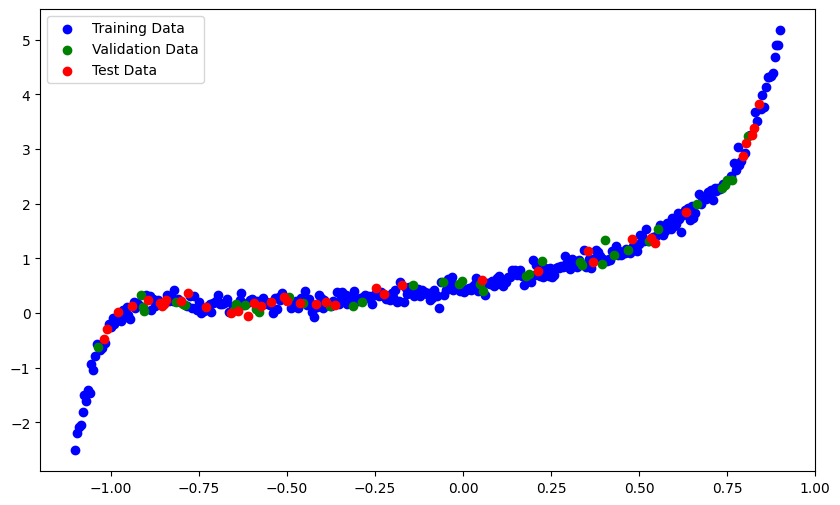

Variance of Training Data: 0.45778604930834293	 Standard Dev of Training Data: 0.676598883614467
Variance of Test Data: 0.5831075338722748	 Standard Dev of Test Data: 0.7636147810724166
Variance of Validation Data: 0.44790890132599676	 Standard Dev of Validation Data: 0.6692599654289779


In [16]:
lr_deg1 = LinearRegression(reg_lambda=0, poly_degree=1, num_features=1, learning_rate=0.1,plot_save=0, num_iter=100, regularization=None)

# fitting on training data 
lr_deg1.fit(train_data_path, val_data_path, test_data_path, figures_directory)

# to represent the train-val-test split through scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(lr_deg1.X_train[:, 1], lr_deg1.y_train, color='blue', label='Training Data')
plt.scatter(lr_deg1.X_val[:, 1], lr_deg1.y_val, color='green', label='Validation Data')
plt.scatter(lr_deg1.X_test[:, 1], lr_deg1.y_test, color='red', label='Test Data')
plt.legend()
plt.show()

print(f"Variance of Training Data: {np.var(lr_deg1.X_train)}\t Standard Dev of Training Data: {np.std(lr_deg1.X_train)}")

print(f"Variance of Test Data: {np.var(lr_deg1.X_test)}\t Standard Dev of Test Data: {np.std(lr_deg1.X_test)}")

print(f"Variance of Validation Data: {np.var(lr_deg1.X_val)}\t Standard Dev of Validation Data: {np.std(lr_deg1.X_val)}")


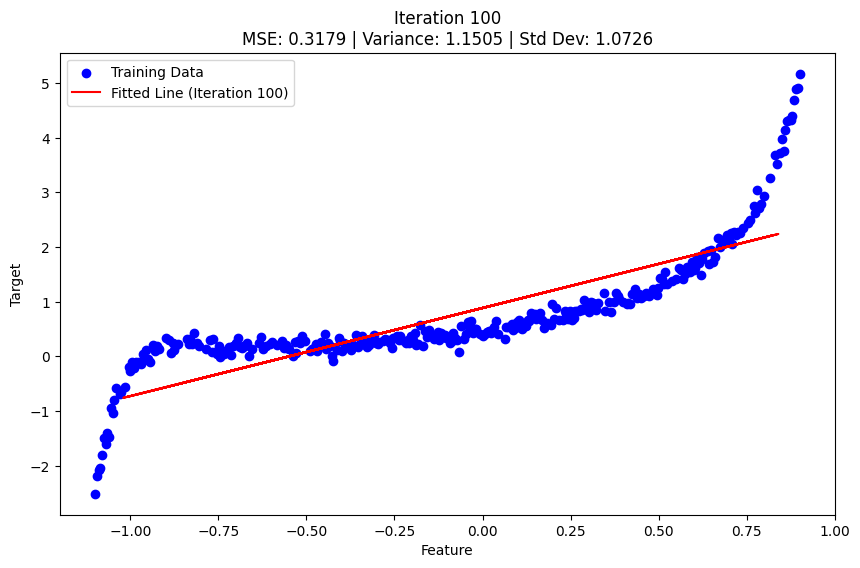

In [17]:
# plotting the final line on test data 
test_y_pred = np.dot(lr_deg1.X_test, lr_deg1.weights)
plt.figure(figsize=(10, 6))
plt.scatter(lr_deg1.X_train[:, 1], lr_deg1.y_train, color='blue', label='Training Data')

# Plot the fitted line
plt.plot(lr_deg1.X_test[:,1], test_y_pred, color='red', label=f'Fitted Line (Iteration {lr_deg1.num_iterations})')

# plt.plot(self.X_train[:, 1], y_pred, color='red', label=f'Fitted Line (Iteration {iteration})')

# Display metrics on the plot
plt.title(f'Iteration {lr_deg1.num_iterations}\nMSE: {lr_deg1.mean_squared_error(lr_deg1.y_test, test_y_pred):.4f} | Variance: {lr_deg1.variance(lr_deg1.y_test):.4f} | Std Dev: {lr_deg1.standard_deviation(lr_deg1.y_test):.4f}')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

In [19]:
def save_best_model(lr_model):
    # Sort grad_desc_iterations by MSE in ascending order
    lr_model.grad_desc_iterations.sort(key=lambda x: x["MSE"])
    
    # Get the best iteration (lowest MSE)
    best_iteration = lr_model.grad_desc_iterations[0]
    
    # File path for saving the best iteration details
    output_file_path = 'best_iteration.txt'
    
    # Open the file in append mode
    with open(output_file_path, 'a') as outfile:
        outfile.write(f"Polynomial Degree: {lr_model.poly_degree}\n")
        outfile.write(f"Iteration Number: {best_iteration['Iteration_Num']}\n")
        outfile.write(f"MSE: {best_iteration['MSE']:.4f}\n")
        outfile.write(f"Variance: {best_iteration['Variance']:.4f}\n")
        outfile.write(f"Standard Deviation: {best_iteration['Standard Deviation']:.4f}\n")
        outfile.write("Weights:\n")
        outfile.write("\n".join([f"  {weight:.4f}" for weight in best_iteration['Weights']]))
        outfile.write("\n\n")  # Add a newline for separation between entries


In [20]:
# lr_deg1 = LinearRegression(reg_lambda=0, poly_degree=1, num_features=1, learning_rate=0.1,plot_save=0, num_iter=100, regularization=None)
# lr_deg1.fit()
# save_best_model(lr_deg1)

# lr_deg2 = LinearRegression(reg_lambda=0, poly_degree=2, num_features=1, learning_rate=0.1,plot_save=0, num_iter=100, regularization=None)
# lr_deg2.fit()
# save_best_model(lr_deg2)

# lr_deg3 = LinearRegression(reg_lambda=0, poly_degree=3, num_features=1, learning_rate=0.1,plot_save=0, num_iter=100, regularization=None)
# lr_deg3.fit()
# save_best_model(lr_deg3)

# lr_deg4 = LinearRegression(reg_lambda=0, poly_degree=4, num_features=1, learning_rate=0.1,plot_save=0, num_iter=100, regularization=None)
# lr_deg4.fit()
# save_best_model(lr_deg4)

# lr_deg5 = LinearRegression(reg_lambda=0, poly_degree=5, num_features=1, learning_rate=0.1,plot_save=0, num_iter=100, regularization=None)
# lr_deg5.fit()
# save_best_model(lr_deg5)

## Observations and Assumptions:

- Degree with minimum MSE: 3
- Number of iterations kept to 100 for all the models, and train-test-val is kept the same for all the models
- All the coefficients are stored in a text file.
- All the GIFs have been made separately, and their code cells have been removed temporarily so that they are not made after every run. 
- All the metrics like MSE, Variance and Standard Dev in GIFs have been obtained from the validation data, as it was required after every iteration of Gradient Descent. So test data has not been used there. Whereas for storing the best model, we used test data to calculate the weights and make the plot above. 
- The MSE in GIFs and best model might differ because of the difference in time of when they were saved and randomness of the weights assigned initially during fit().


## Script to generate the GIF 

In [21]:
def make_animation(poly_degree):

    # Function to extract numeric parts of the filename for sorting
    def extract_number(filename):
        # Extract all numeric parts from the filename
        numbers = re.findall(r'\d+', os.path.basename(filename))
        # Convert to integers for proper numeric comparison
        return list(map(int, numbers))
    # Initialize some settings
    image_folder = figures_directory
    output_gif_path = f'../../assignments/1/animation/new/without_seeding/animation_deg{poly_degree}.gif'

    duration_per_frame = 100  # milliseconds

    # Collect all image paths
    image_paths = glob.glob(f"{image_folder}*.png")
    image_paths.sort(key=extract_number)  # Sort the images to maintain sequence; adjust as needed
    # print(image_paths)

    # Initialize an empty list to store the images
    frames = []

    # # Debugging lines (moved here, after frames is initialized)
    # print("Number of frames: ", len(frames))
    # print("Image Paths: ", image_paths)

    # Loop through each image file to add text and append to frames
    for image_path in image_paths:
        img = Image.open(image_path)

        # Reduce the frame size by 50%
        img = img.resize((int(img.width * 0.5), int(img.height * 0.5)))

        # Create a new draw object after resizing
        draw = ImageDraw.Draw(img)

        # Text to display at top-left and bottom-right corners
        top_left_text = image_path.split("/")[-1]
        bottom_right_text = "Add your test here to be displayed on Images"

        # Font settings
        font_path = "/Library/Fonts/Arial.ttf"  # Replace with the path to a .ttf file on your system
        font_size = 20
        font = ImageFont.truetype(font_path, font_size)

        # Draw top-left text
        draw.text((10, 10), top_left_text, font=font, fill=(255, 255, 255))

        # Calculate x, y position of the bottom-right text
        text_width, text_height = draw.textsize(bottom_right_text, font=font)
        x = img.width - text_width - 10  # 10 pixels from the right edge
        y = img.height - text_height - 10  # 10 pixels from the bottom edge

        # Draw bottom-right text
        draw.text((x, y), bottom_right_text, font=font, fill=(255, 255, 255))

        frames.append(img)

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
    out = cv2.VideoWriter(f'lr_degree_{1}.mp4', fourcc, 20.0, (int(img.width), int(img.height)))

    # Loop through each image frame (assuming you have the frames in 'frames' list)
    for img_pil in frames:
        # Convert PIL image to numpy array (OpenCV format)
        img_np = np.array(img_pil)

        # Convert RGB to BGR (OpenCV uses BGR instead of RGB)
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Write frame to video
        out.write(img_bgr)

    # Release the VideoWriter
    out.release()

    # Save frames as an animated GIF
    frames[0].save(output_gif_path,
                save_all=True,
                append_images=frames[1:],
                duration=duration_per_frame,
                loop=0,
                optimize=True)


In [22]:
lr_deg1 = LinearRegression(reg_lambda=0, poly_degree=1, num_features=1, learning_rate=0.1,plot_save=1, num_iter=150, regularization=None)
lr_deg1.fit(train_data_path, val_data_path, test_data_path, figures_directory)
save_best_model(lr_deg1)
make_animation(lr_deg1.poly_degree)

/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2

In [23]:
lr_deg2 = LinearRegression(reg_lambda=0, poly_degree=2, num_features=1, learning_rate=0.1,plot_save=1, num_iter=150, regularization=None)
lr_deg2.fit(train_data_path, val_data_path, test_data_path, figures_directory)
save_best_model(lr_deg2)
make_animation(lr_deg2.poly_degree)


/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2

In [24]:

lr_deg3 = LinearRegression(reg_lambda=0, poly_degree=3, num_features=1, learning_rate=0.1,plot_save=1, num_iter=150, regularization=None)
lr_deg3.fit(train_data_path, val_data_path, test_data_path, figures_directory)
save_best_model(lr_deg3)
make_animation(lr_deg3.poly_degree)


/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2

In [25]:

lr_deg4 = LinearRegression(reg_lambda=0, poly_degree=4, num_features=1, learning_rate=0.1,plot_save=1, num_iter=150, regularization=None)
lr_deg4.fit(train_data_path, val_data_path, test_data_path, figures_directory)
save_best_model(lr_deg4)
make_animation(lr_deg4.poly_degree)


/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2

In [26]:

lr_deg5 = LinearRegression(reg_lambda=0, poly_degree=5, num_features=1, learning_rate=0.1,plot_save=1, num_iter=150, regularization=None)
lr_deg5.fit(train_data_path, val_data_path, test_data_path, figures_directory)
save_best_model(lr_deg5)
make_animation(lr_deg5.poly_degree)

/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(bottom_right_text, font=font)
/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_25440/725085699.py:50: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2

In [ ]:
# Initialize lists to store metrics for each degree
degrees = []
mses = []
variances = []
std_devs = []
convergences = []

# Loop over each degree from 1 to 30
for deg in range(1, 31):
    lr_deg = LinearRegression(reg_lambda=0.1, poly_degree=deg, num_features=1, learning_rate=0.1, plot_save=0, num_iter=150, regularization=None)
    lr_deg.fit(train_data_path, val_data_path, test_data_path, figures_directory)
    
    # Calculate predictions on the test set
    test_y_pred = np.dot(lr_deg.X_test, lr_deg.weights)
    
    # Calculate metrics
    mse = lr_deg.mean_squared_error(lr_deg.y_test, test_y_pred)
    var = lr_deg.variance(test_y_pred)
    std_dev = lr_deg.standard_deviation(test_y_pred)
    convergence = lr_deg.grad_desc_iterations[-1]['Iteration_Num'] if lr_deg.grad_desc_iterations else None
    
    # Store metrics in lists
    degrees.append(deg)
    mses.append(mse)
    variances.append(var)
    std_devs.append(std_dev)
    convergences.append(convergence)
    
# Create a DataFrame for easy viewing
results_df = pd.DataFrame({
    'Degree': degrees,
    'MSE': mses,
    'Variance': variances,
    'Std Dev': std_devs,
    'Convergence Iteration': convergences
})

# Print the DataFrame
print(results_df)

# Find the degree with the minimum MSE
min_mse_degree = results_df.loc[results_df['MSE'].idxmin()]

print(f"The degree with the minimum MSE is {min_mse_degree['Degree']} with an MSE of {min_mse_degree['MSE']:.4f}")

# Plot MSE vs Degree
plt.figure(figsize=(10, 6))
plt.plot(degrees, mses, marker='o', linestyle='-', color='blue')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(degrees)
plt.grid(True)
plt.show()

In [2]:
# class LinearRegression:
#     def __init__(self, reg_lambda, poly_degree, num_features, learning_rate, dataset_csv, num_iter=1000, regularization=None):
#         self.reg_lambda = reg_lambda  # Regularization parameter
#         self.poly_degree = poly_degree  # Degree of polynomial features
#         self.num_features = num_features  # Number of features in the dataset
#         self.learning_rate = learning_rate  # Learning rate for gradient descent
#         self.num_iterations = num_iter  # Number of iterations for gradient descent
#         self.weights = None  # Weights for the model
#         self.dataset = dataset_csv  # Path to the dataset CSV file
#         self.X_train = None
#         self.X_val = None
#         self.X_test = None
#         self.y_train = None
#         self.y_val = None
#         self.y_test = None
#         self.regularization = regularization  # Regularization type: 'L1', 'L2', or None

#     def _polynomial_features(self, X):
#         """Generate polynomial features up to the specified degree."""
#         X_poly = X.copy()
#         for degree in range(2, self.poly_degree + 1):
#             X_poly = np.hstack((X_poly, np.power(X, degree)))
#         return X_poly

#     def fit(self):
#         # Load the data from the CSV file
#         data = pd.read_csv(self.dataset)

#         # Shuffle the data
#         data = data.sample(frac=1).reset_index(drop=True)

#         # Split the data into features (X) and target (y)
#         X_pts = data.iloc[:, :-1].values  # Assuming all columns except last are features
#         Y_pts = data.iloc[:, -1].values  # Assuming last column is the target

#         # Generate polynomial features
#         X_poly = self._polynomial_features(X_pts)

#         # Add a column of 1s to X_poly to incorporate the bias term into the weights
#         X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))

#         # Split the data into train (80%), validation (10%), and test (10%) sets
#         train_size = int(0.8 * len(X_pts))
#         val_size = int(0.1 * len(X_pts))

#         # Training set
#         self.X_train = X_poly[:train_size]
#         self.y_train = Y_pts[:train_size]

#         # Validation set
#         self.X_val = X_poly[train_size:train_size + val_size]
#         self.y_val = Y_pts[train_size:train_size + val_size]

#         # Test set
#         self.X_test = X_poly[train_size + val_size:]
#         self.y_test = Y_pts[train_size + val_size:]

#         # Initialize weights (including bias)
#         self.weights = np.random.randn(self.X_train.shape[1])

#         # Gradient descent
#         for i in range(self.num_iterations):
#             # Compute predictions
#             y_pred = np.dot(self.X_train, self.weights)

#             # Compute gradients
#             error = y_pred - self.y_train
#             dw = (2 / len(self.X_train)) * np.dot(self.X_train.T, error)

#             # Add regularization term
#             if self.regularization == 'L2':
#                 dw += (2 * self.reg_lambda * self.weights)
#             elif self.regularization == 'L1':
#                 dw += self.reg_lambda * np.sign(self.weights)

#             # Update weights
#             self.weights -= self.learning_rate * dw

#         return self

#     # def validate_trained_model(self):
        
        
#     def predict(self, X):
#         """Predicts output using the trained model."""
#         # Add a column of 1s to X to incorporate the bias term
#         X_poly = self._polynomial_features(X)
#         X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))
#         return np.dot(X_poly, self.weights)

#     def mean_squared_error(self, y_true, y_pred):
#         """Calculate the Mean Squared Error (MSE)."""
#         return np.mean((y_true - y_pred) ** 2)

#     def variance(self, y):
#         """Calculate the variance of the data points."""
#         return np.var(y)

#     def standard_deviation(self, y):
#         """Calculate the standard deviation of the data points."""
#         return np.std(y)

#     def evaluate(self):
#         """Evaluate the model on the test set."""
#         y_pred_test = self.predict(self.X_test)
#         mse = self.mean_squared_error(self.y_test, y_pred_test)
#         var = self.variance(self.y_test)
#         std_dev = self.standard_deviation(self.y_test)
#         return {"MSE":mse, "Variance":var, "Standard Deviation":std_dev}

## Without Regularisation (degrees>5)

In [56]:
csv_dataset = '../../data/external/regularisation.csv'
train_data_path = '../../data/interim/1/reg/regu_train.csv'
test_data_path = '../../data/interim/1/reg/regu_test.csv'
val_data_path = '../../data/interim/1/reg/regu_val.csv'
figures_directory = '../../assignments/1/figures/'

# Load the data from the CSV file
data = pd.read_csv(csv_dataset)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
# # Split the data into features (X) and target (y)
# X_pts = data.iloc[:, :-1].values  # Assuming all columns except last are features
# Y_pts = data.iloc[:, -1].values  # Assuming last column is the target

train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))


train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Write the training data to the specified path
train_data.to_csv(train_data_path, index=False)

# Write the validation data to the specified path
val_data.to_csv(val_data_path, index=False)

# Write the test data to the specified path
test_data.to_csv(test_data_path, index=False)

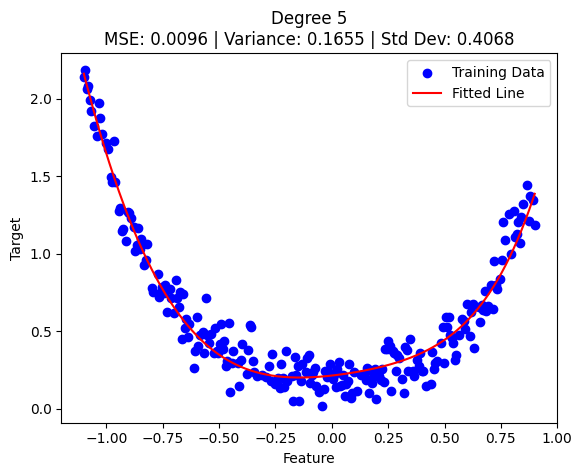

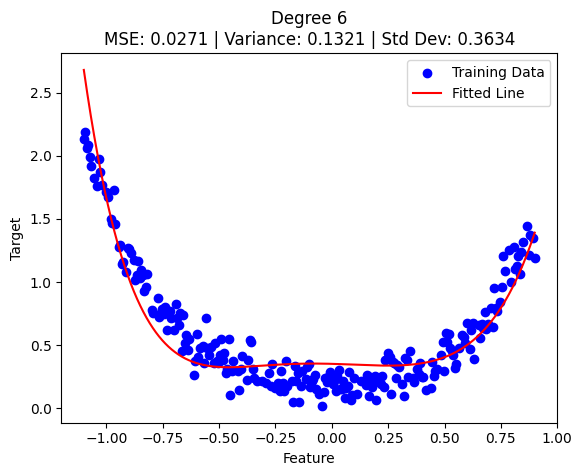

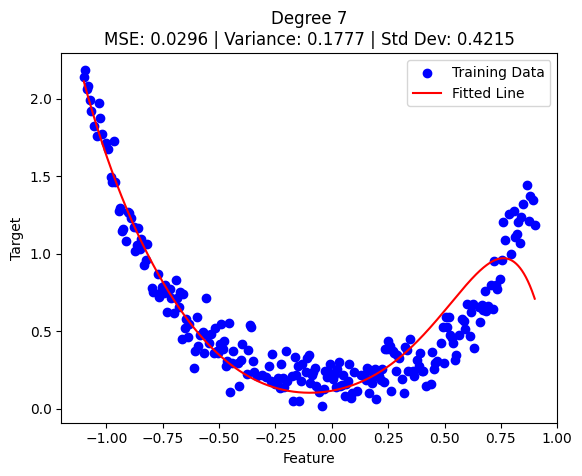

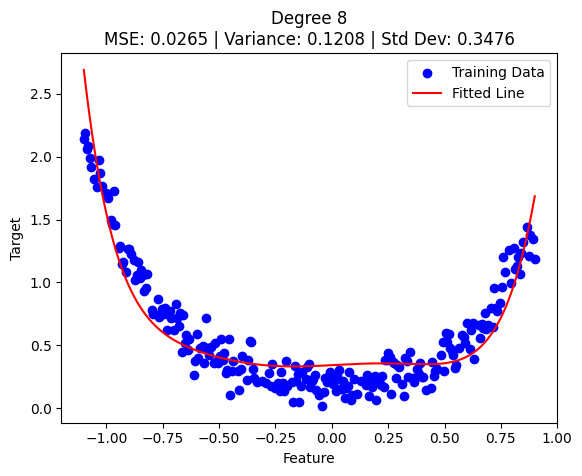

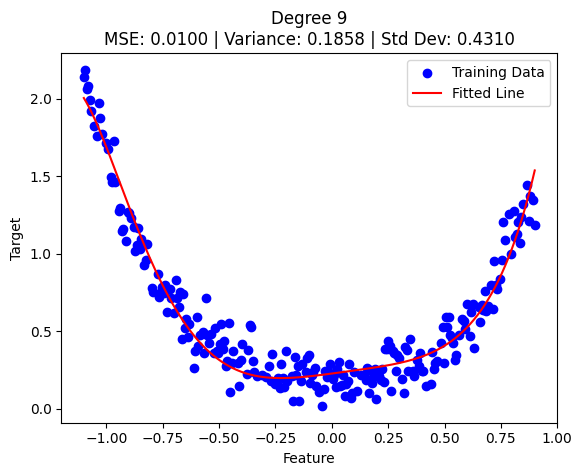

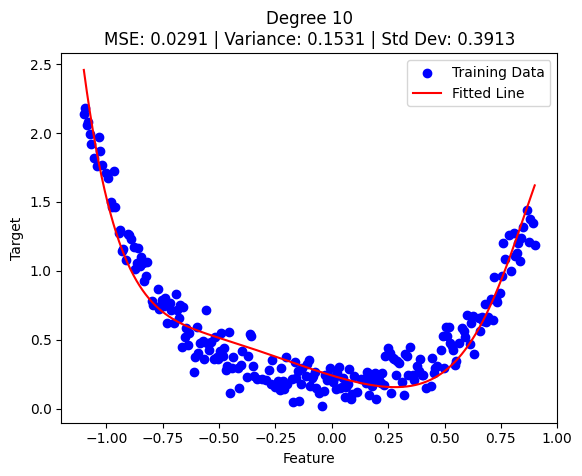

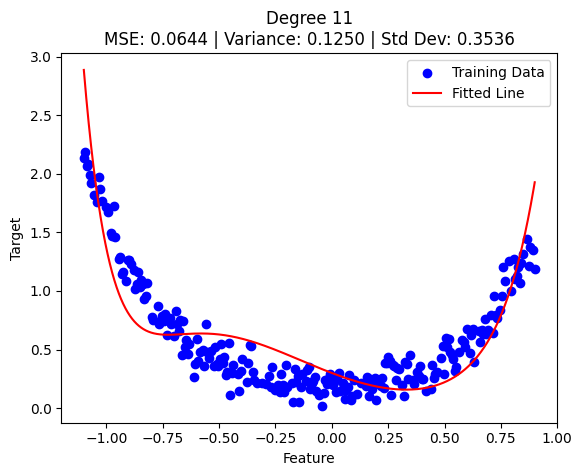

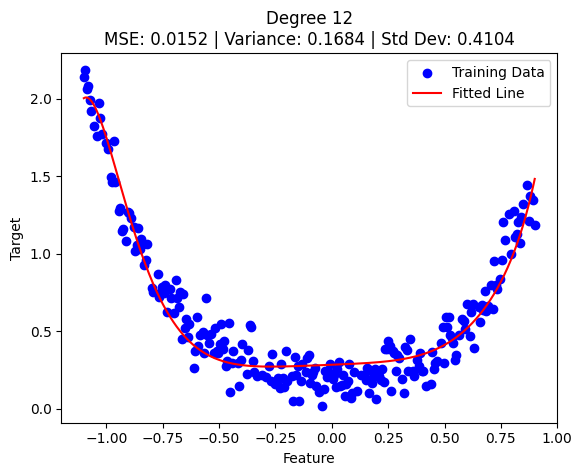

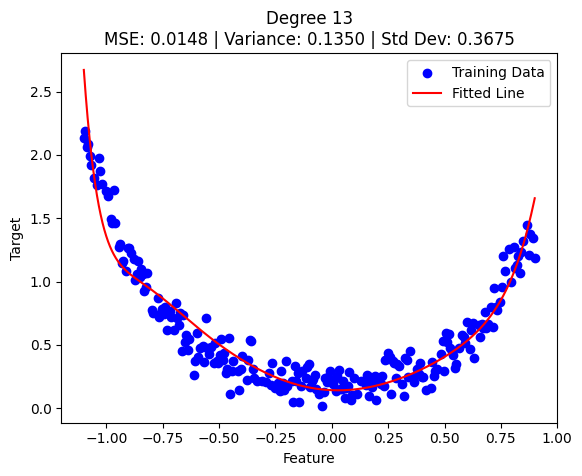

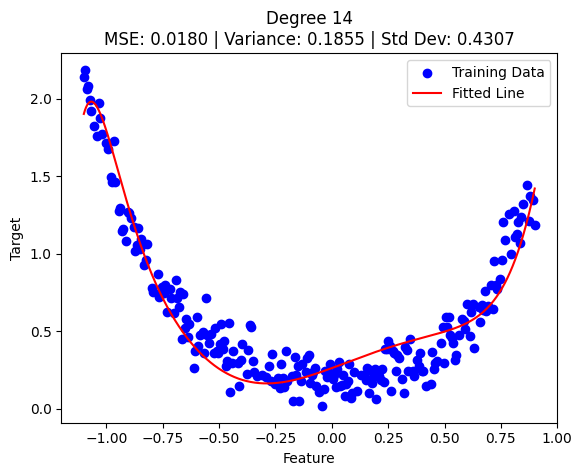

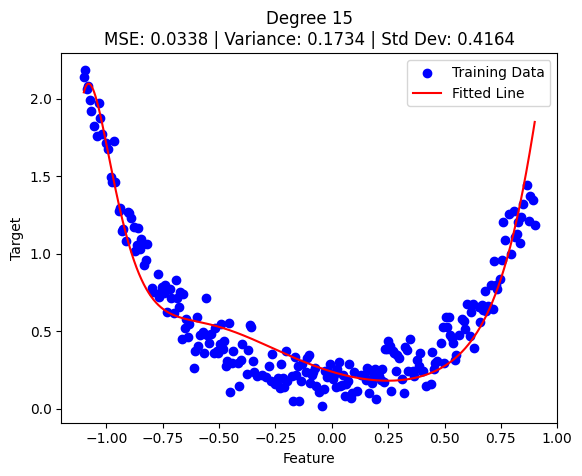

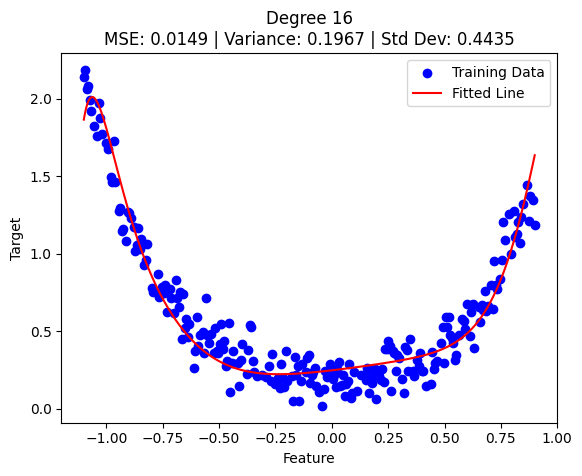

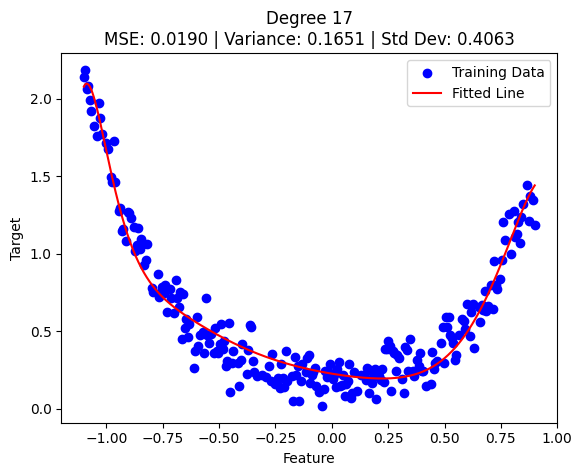

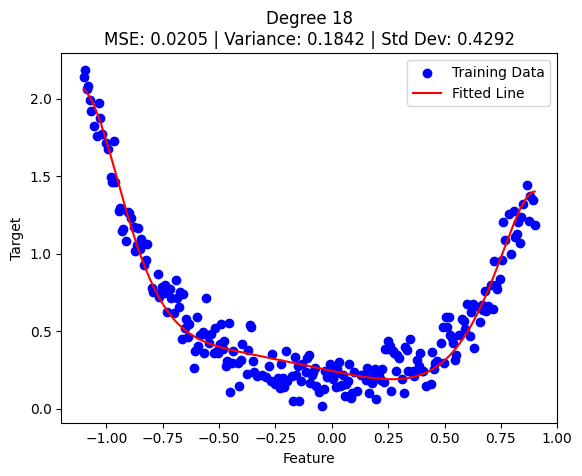

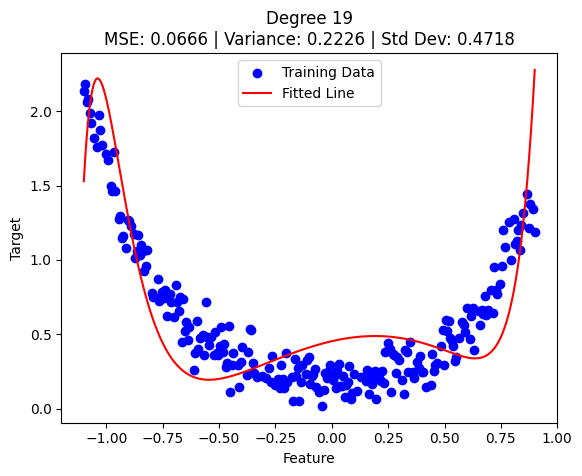

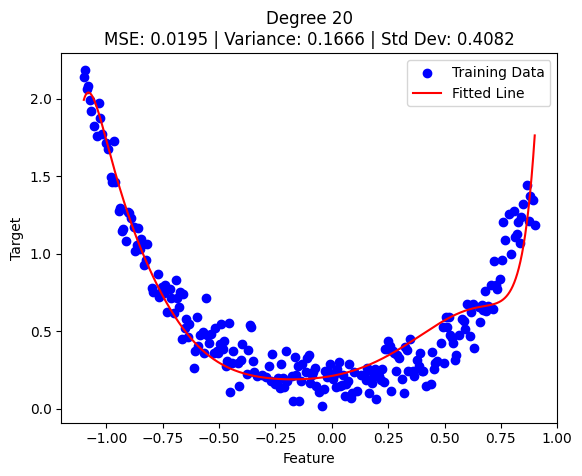

In [63]:
for deg in range(5, 21):
    lr_regu = LinearRegression(reg_lambda=0.1, poly_degree=deg, num_features=1, learning_rate=0.1, plot_save=0, num_iter=150, regularization=None)
    lr_regu.fit(train_data_path, val_data_path, test_data_path, figures_directory)
    
    # Calculate predictions on the test set
    test_y_pred = np.dot(lr_regu.X_test, lr_regu.weights)
    
    # Plotting the training data and fitted line on the test set
    # plt.figure(figsize=(10, 6))
    # plt.scatter(lr_regu.X_train[:, 1], lr_regu.y_train, color='blue', label='Test Data')  # Use test data here

    # Plot the fitted line
    # plt.plot(lr_regu.X_test[:, 1], test_y_pred, color='red', label=f'Fitted Line (Degree {deg})')
    # lr_regu._plot_iteration(iteration=150)

    # Calculate and display metrics
    mse = lr_regu.mean_squared_error(lr_regu.y_test, test_y_pred)
    var = lr_regu.variance(test_y_pred)
    std_dev = lr_regu.standard_deviation(test_y_pred)
    
    # plt.xlabel('Feature')
    # plt.ylabel('Target')
    # plt.legend()
    plt.scatter(lr_regu.X_train[:, 1], lr_regu.y_train, color='blue', label='Training Data')
    x_range = np.linspace(min(lr_regu.X_train[:, 1]), max(lr_regu.X_train[:, 1]), 10000)
    X_poly = np.vander(x_range, N=lr_regu.poly_degree + 1, increasing=True)
    y_range_pred = np.dot(X_poly, lr_regu.weights)
    plt.plot(x_range, y_range_pred, color='red', label=f'Fitted Line')
    plt.title('Training Data and Fitted Line')
    plt.title(f'Degree {lr_regu.poly_degree}\nMSE: {mse:.4f} | Variance: {var:.4f} | Std Dev: {std_dev:.4f} | Convergence: {lr_regu.convergence_iter}')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.show()


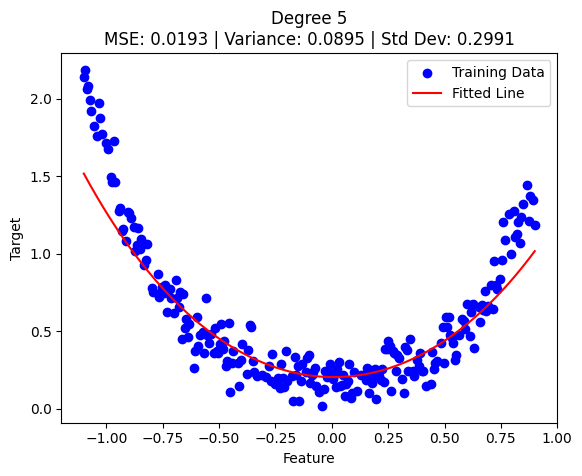

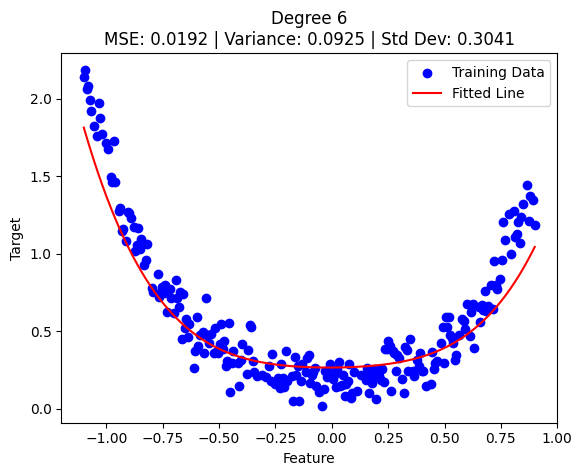

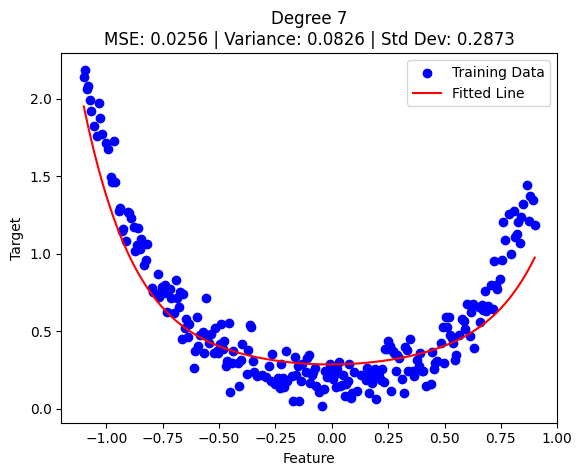

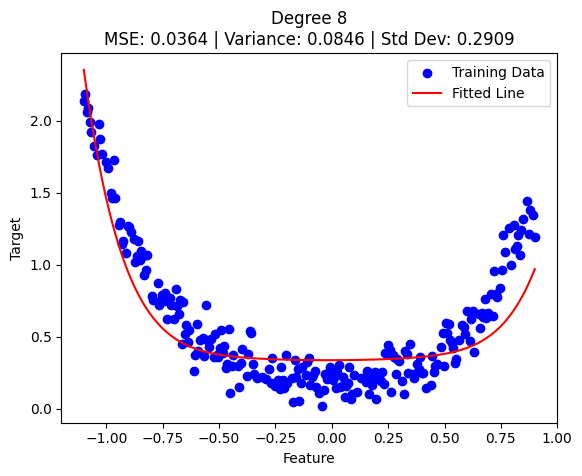

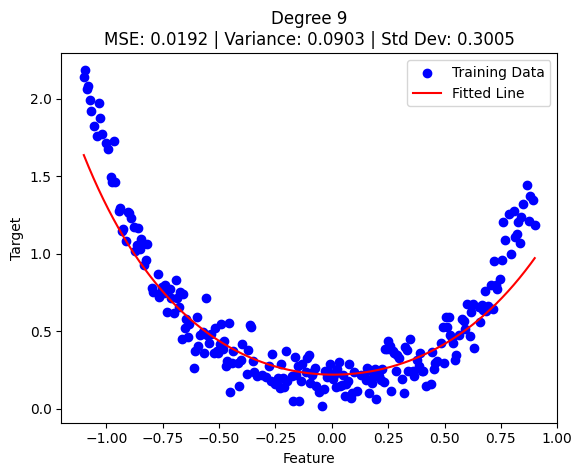

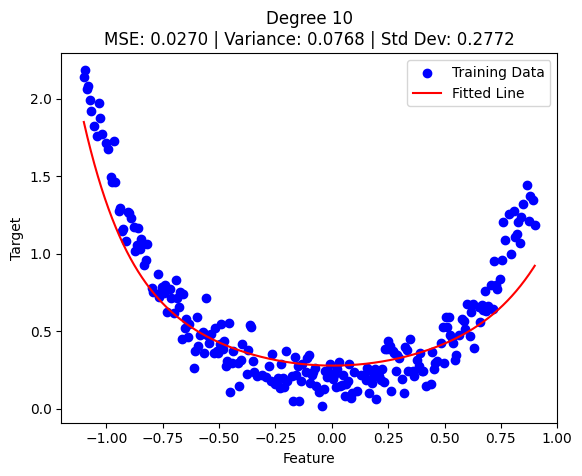

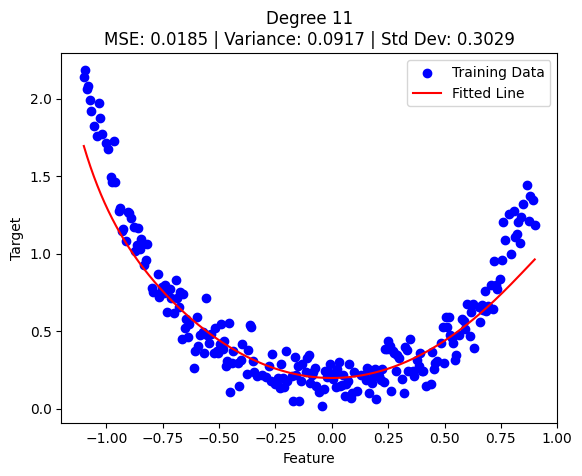

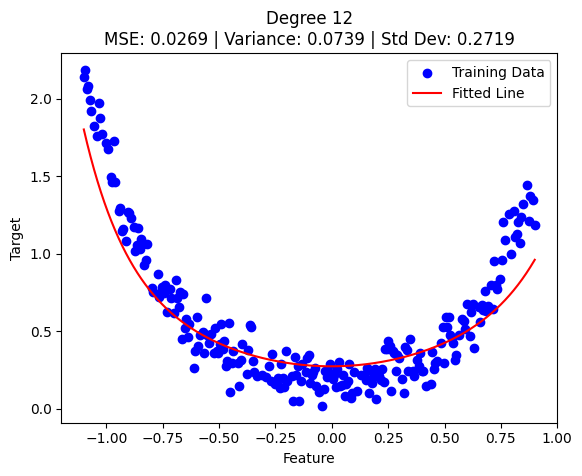

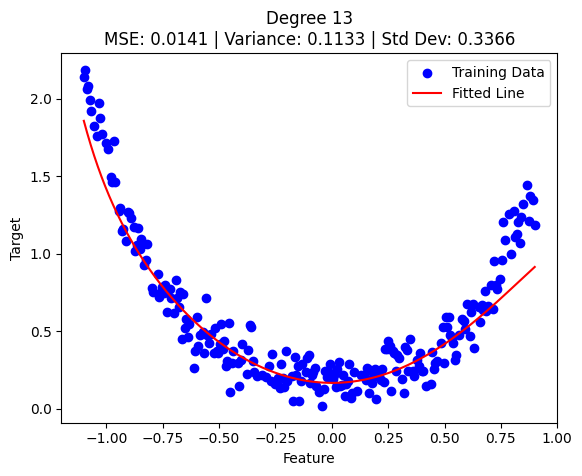

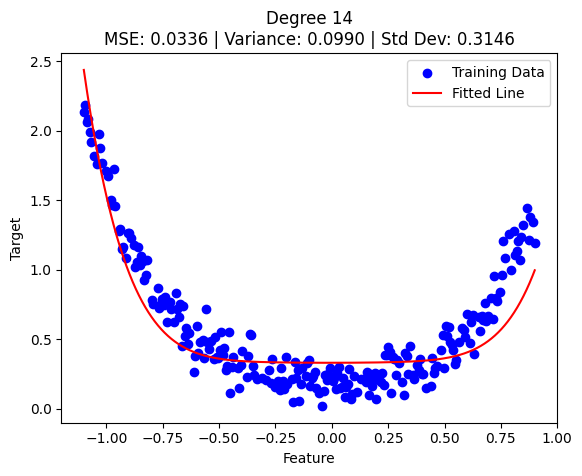

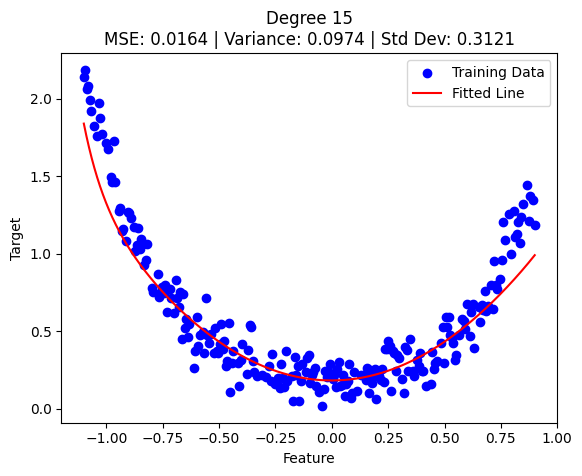

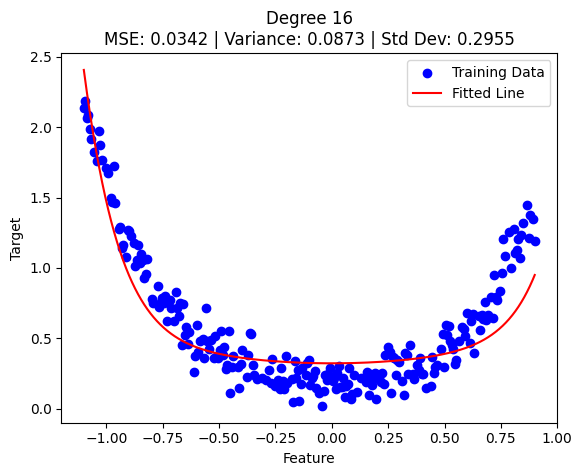

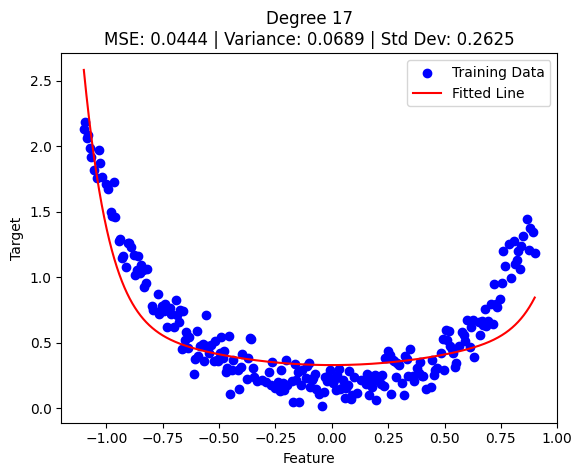

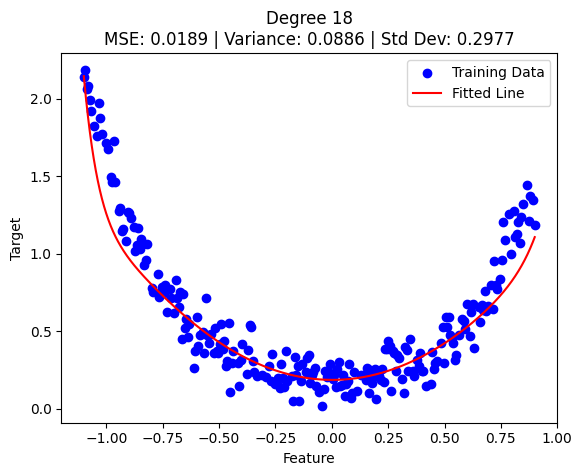

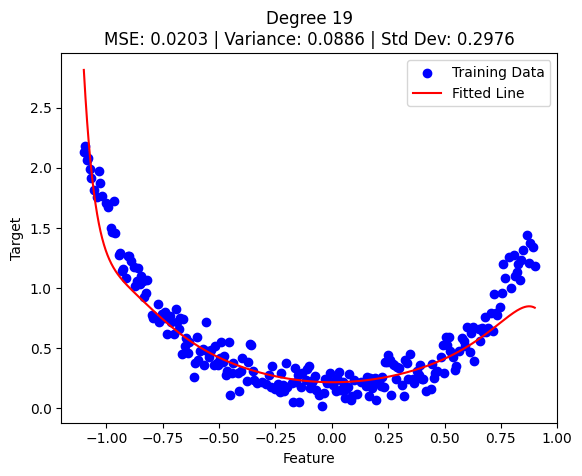

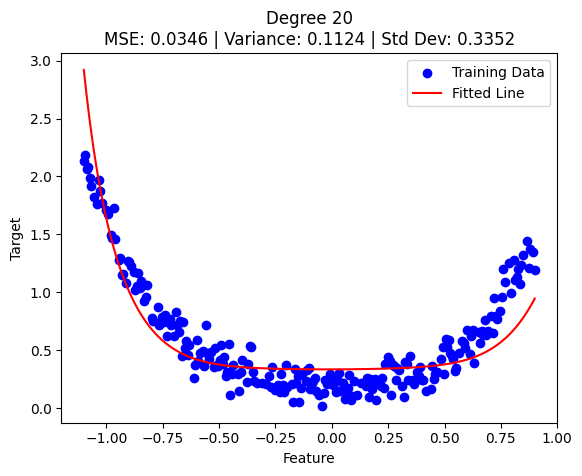

In [64]:
# with L1 regularization 
for deg in range(5, 21):
    lr_regu = LinearRegression(reg_lambda=0.1, poly_degree=deg, num_features=1, learning_rate=0.1, plot_save=0, num_iter=150, regularization="L1")
    lr_regu.fit()
    
    # Calculate predictions on the test set
    test_y_pred = np.dot(lr_regu.X_test, lr_regu.weights)
    
    # Plotting the training data and fitted line on the test set
    # plt.figure(figsize=(10, 6))
    # plt.scatter(lr_regu.X_train[:, 1], lr_regu.y_train, color='blue', label='Test Data')  # Use test data here

    # Plot the fitted line
    # plt.plot(lr_regu.X_test[:, 1], test_y_pred, color='red', label=f'Fitted Line (Degree {deg})')
    # lr_regu._plot_iteration(iteration=150)

    # Calculate and display metrics
    mse = lr_regu.mean_squared_error(lr_regu.y_test, test_y_pred)
    var = lr_regu.variance(test_y_pred)
    std_dev = lr_regu.standard_deviation(test_y_pred)
    
    # plt.xlabel('Feature')
    # plt.ylabel('Target')
    # plt.legend()
    plt.scatter(lr_regu.X_train[:, 1], lr_regu.y_train, color='blue', label='Training Data')
    x_range = np.linspace(min(lr_regu.X_train[:, 1]), max(lr_regu.X_train[:, 1]), 10000)
    X_poly = np.vander(x_range, N=lr_regu.poly_degree + 1, increasing=True)
    y_range_pred = np.dot(X_poly, lr_regu.weights)
    plt.plot(x_range, y_range_pred, color='red', label=f'Fitted Line')
    plt.title('Training Data and Fitted Line')
    plt.title(f'Degree {lr_regu.poly_degree}\nMSE: {mse:.4f} | Variance: {var:.4f} | Std Dev: {std_dev:.4f}')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.show()


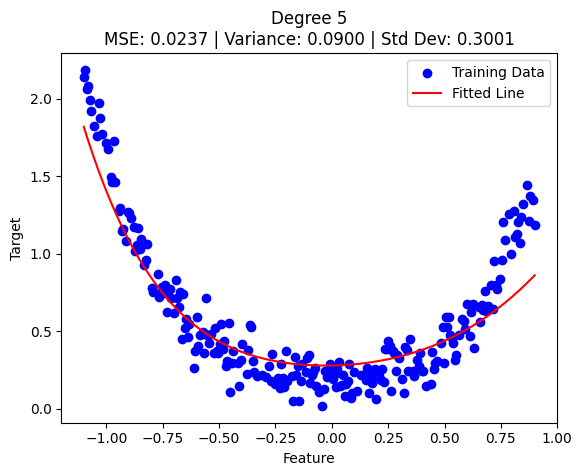

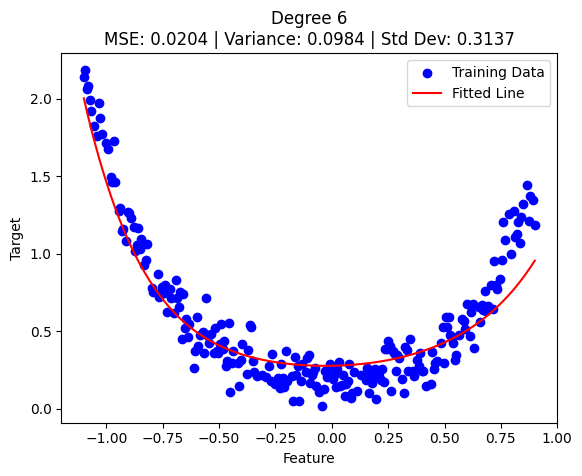

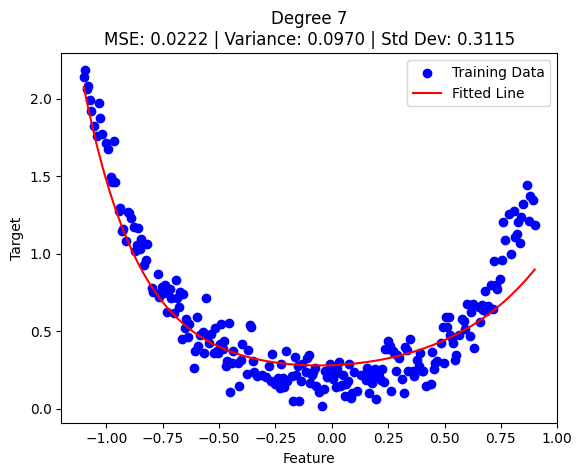

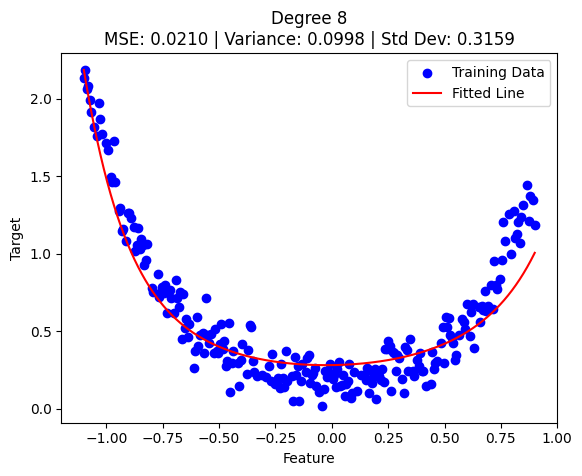

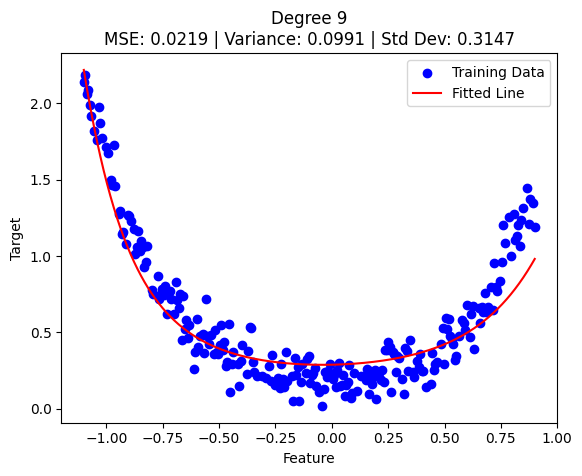

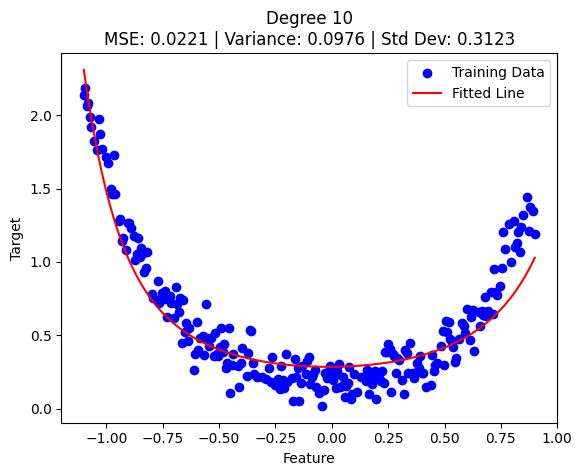

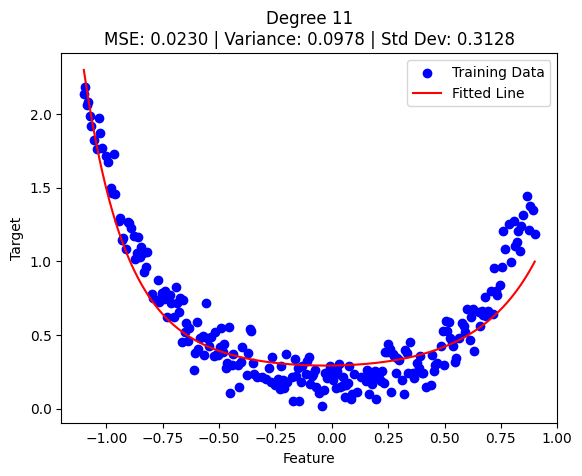

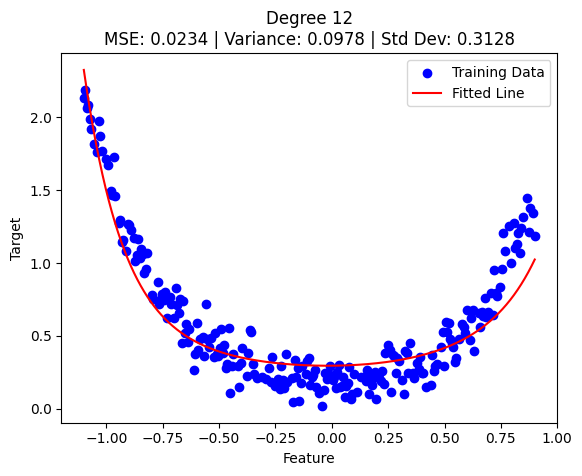

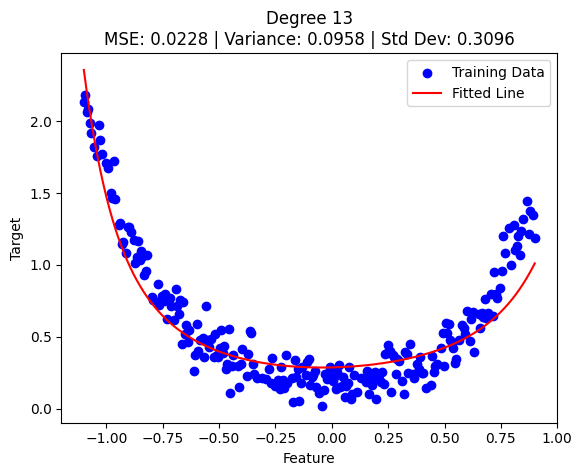

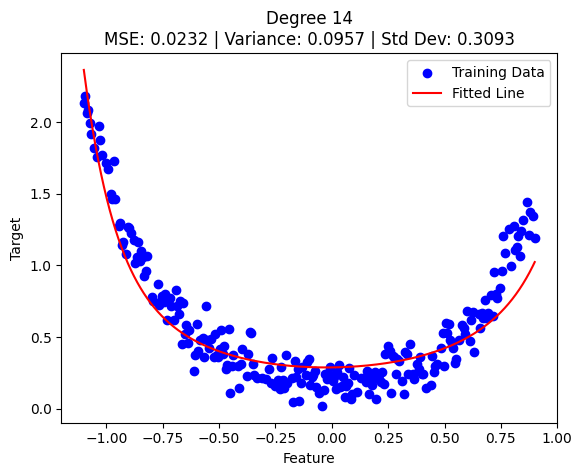

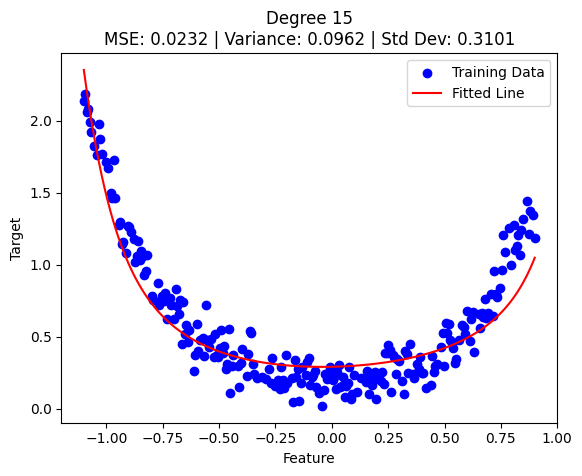

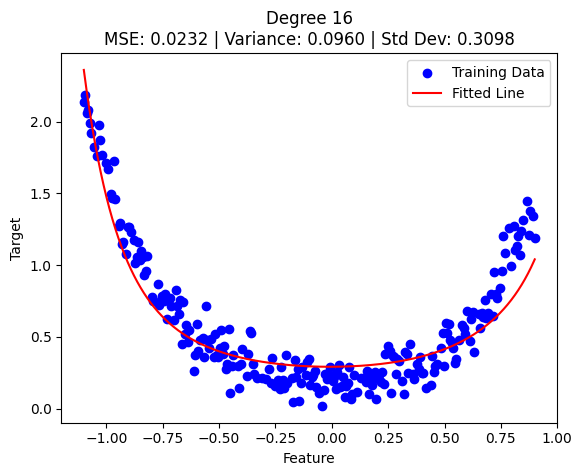

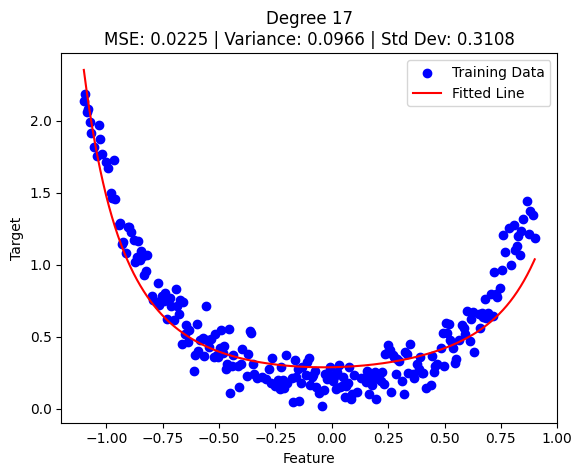

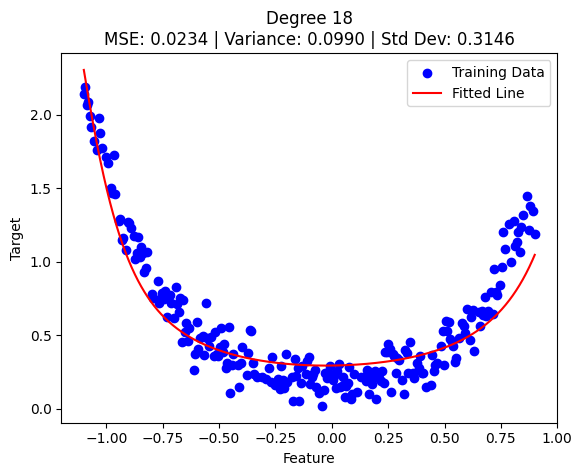

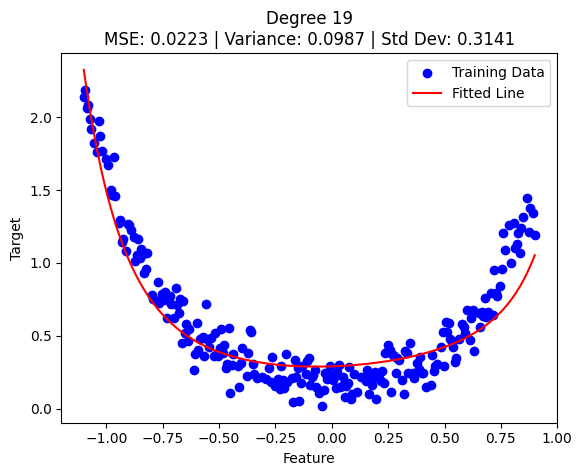

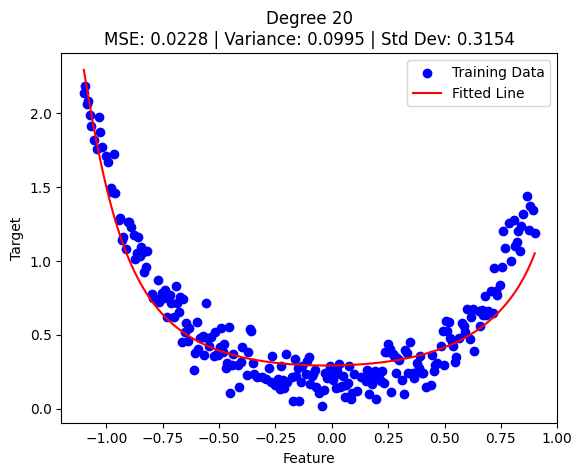

In [65]:
# with L2 regularization
for deg in range(5, 21):
    lr_regu = LinearRegression(reg_lambda=0.1, poly_degree=deg, num_features=1, learning_rate=0.1, plot_save=0, num_iter=150, regularization="L2")
    lr_regu.fit()
    
    # Calculate predictions on the test set
    test_y_pred = np.dot(lr_regu.X_test, lr_regu.weights)
    
    # Plotting the training data and fitted line on the test set
    # plt.figure(figsize=(10, 6))
    # plt.scatter(lr_regu.X_train[:, 1], lr_regu.y_train, color='blue', label='Test Data')  # Use test data here

    # Plot the fitted line
    # plt.plot(lr_regu.X_test[:, 1], test_y_pred, color='red', label=f'Fitted Line (Degree {deg})')
    # lr_regu._plot_iteration(iteration=150)

    # Calculate and display metrics
    mse = lr_regu.mean_squared_error(lr_regu.y_test, test_y_pred)
    var = lr_regu.variance(test_y_pred)
    std_dev = lr_regu.standard_deviation(test_y_pred)
    
    # plt.xlabel('Feature')
    # plt.ylabel('Target')
    # plt.legend()
    plt.scatter(lr_regu.X_train[:, 1], lr_regu.y_train, color='blue', label='Training Data')
    x_range = np.linspace(min(lr_regu.X_train[:, 1]), max(lr_regu.X_train[:, 1]), 10000)
    X_poly = np.vander(x_range, N=lr_regu.poly_degree + 1, increasing=True)
    y_range_pred = np.dot(X_poly, lr_regu.weights)
    plt.plot(x_range, y_range_pred, color='red', label=f'Fitted Line')
    plt.title('Training Data and Fitted Line')
    plt.title(f'Degree {lr_regu.poly_degree}\nMSE: {mse:.4f} | Variance: {var:.4f} | Std Dev: {std_dev:.4f}')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.show()
